In [40]:
import mlflow

mlflow.set_tracking_uri(uri="http://localhost:5000")

In [41]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, make_scorer, confusion_matrix
from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib





In [42]:
# Chargement des données
data = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/data_preprocessed_train.csv')

# Vérifier la présence de la colonne TARGET
if 'TARGET' not in data.columns:
    raise ValueError("La colonne 'TARGET' n'est pas présente dans les données.")

# Séparation des caractéristiques (X) et de la cible (y)
X = data.drop(columns=['TARGET'])  # Caractéristiques
y = data['TARGET']  # Cible



In [43]:


# Calcul de la matrice de corrélation
correlation_matrix = data.corr()

# Affichage de la matrice de corrélation sous forme de heatmap
#plt.figure(figsize=(12, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#plt.title('Matrice de Corrélation entre les Variables')
#plt.show()

# Affichage des corrélations avec la cible
target_corr = correlation_matrix['TARGET'].sort_values(ascending=False)
print("Corrélations avec la cible (TARGET) :")
print(target_corr)



Corrélations avec la cible (TARGET) :
TARGET                         1.000000
BUREAU_DAYS_CREDIT_MEAN        0.089729
DAYS_BIRTH                     0.078239
BUREAU_DAYS_CREDIT_MIN         0.075248
REGION_RATING_CLIENT_W_CITY    0.060893
                                 ...   
FLOORSMAX_AVG                 -0.044003
DAYS_EMPLOYED                 -0.044932
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_3                  -0.178919
Name: TARGET, Length: 128, dtype: float64


Interprétation des résultats :

    Corrélation de la cible avec elle-même :
        La variable cible (TARGET) a une corrélation de 1.0 avec elle-même, ce qui est normal et attendu, car une variable est toujours parfaitement corrélée avec elle-même.

    Corrélations faibles avec les autres variables :
        Les autres variables, telles que OCCUPATION_TYPE, DAYS_BIRTH, ORGANIZATION_TYPE, et les autres, ont toutes des corrélations faibles avec la cible (par exemple, des valeurs autour de 0.08, -0.04, etc.), ce qui signifie qu'il n'y a pas de relation évidente entre ces variables et la cible.
        Ces faibles corrélations indiquent que les variables d'entrée ne contiennent pas de fuite directe d'informations sur la cible.

    Aucune variable n'est fortement corrélée :
        Aucune variable n'a une corrélation élevée (supérieure à 0.8 ou inférieure à -0.8) avec la cible. Cela signifie qu'il n'y a pas de problème évident de data leakage, car aucune variable n'est directement liée à la variable cible de manière à ce que le modèle puisse "voir" la réponse pendant l'apprentissage.

Conclusion :

Il semble que vos données soient propres en termes de data leakage

Ancienneté de l'emploi

Âge de l'emprunteur : Si vous avez une colonne de dates de naissance (DAYS_BIRTH), vous pouvez la transformer en âge en années.


Interaction entre le revenu et le crédit : L'inclusion d'une variable qui indique l'interaction entre le revenu annuel et le montant du crédit peut capturer des informations supplémentaires sur la capacité de remboursement.



### Création de nouvelles variables

In [51]:

#Interaction entre le revenu et le crédit : L'inclusion d'une variable qui indique l'interaction entre 
#le revenu annuel et le montant du crédit peut capturer des informations supplémentaires sur la capacité de remboursement.
X['income_credit_ratio'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
#X_test['income_credit_ratio'] = X_test['AMT_INCOME_TOTAL'] / X_test['AMT_CREDIT']

X['age'] = -X['DAYS_BIRTH'] / 365
#X_test['age'] = -X_test['DAYS_BIRTH'] / 365

X['years_employed'] = -X['DAYS_EMPLOYED'] / 365
#X_test['years_employed'] = -X_test['DAYS_EMPLOYED'] / 365

X['log_AMT_INCOME_TOTAL'] = np.log1p(X['AMT_INCOME_TOTAL'])
#X_test['log_AMT_INCOME_TOTAL'] = np.log1p(X_test['AMT_INCOME_TOTAL'])


Interaction entre l'annuité et le revenu : Cela peut aider à identifier des relations entre la capacité de remboursement et la mensualité du prêt.



In [52]:
#Interaction entre l'annuité et le revenu : Cela peut aider à identifier des relations entre la capacité de remboursement et la mensualité du prêt.

X['annuity_income_ratio'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
#X_test['annuity_income_ratio'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']



 les variables comme le revenu ou le crédit suivent une distribution asymétrique, une transformation logarithmique peut rendre leur distribution plus normale et améliorer la performance des modèles.


In [53]:
# les variables comme le revenu ou le crédit suivent une distribution asymétrique,
#une transformation logarithmique peut rendre leur distribution plus normale et améliorer la performance des modèles.
X['log_AMT_INCOME_TOTAL'] = np.log1p(X['AMT_INCOME_TOTAL'])
#X_test['log_AMT_INCOME_TOTAL'] = np.log1p(X_test['AMT_INCOME_TOTAL'])


X['log_AMT_CREDIT'] = np.log1p(X['AMT_CREDIT'])
#X_test['log_AMT_CREDIT'] = np.log1p(X_test['AMT_CREDIT'])

In [54]:
 ##Moins de jours de travail : Cette variable peut indiquer si l'emprunteur a eu une interruption dans son emploi.

X['is_employed'] = X['DAYS_EMPLOYED'].apply(lambda x: 1 if x > 0 else 0)
#X_test['is_employed'] = X_test['DAYS_EMPLOYED'].apply(lambda x: 1 if x > 0 else 0)


In [55]:
#Risque d'endettement :Vous pourriez créer une variable qui mesure le rapport entre le montant du crédit et le revenu, ce qui pourrait donner une idée de l'endettement relatif.
X['credit_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
#X_test['credit_income_ratio'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']


In [56]:
#Taux d’endettement total : Par exemple, le ratio entre l'annuité et le revenu peut indiquer si l’emprunteur a un taux d’endettement élevé.
X['debt_to_income_ratio'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
#X_test['debt_to_income_ratio'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']


In [57]:
# Séparer en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions après séparation
print(f"Shapes after split:\nX_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")



Shapes after split:
X_train: (246008, 152), X_test: (61503, 152), y_train: (246008,), y_test: (61503,)


In [25]:
# Enregistrer X_train et X_test en format CSV
X_train.to_csv('/home/machou/openclassroom/projet/api/data/X_train.csv', index=False)
X_test.to_csv('/home/machou/openclassroom/projet/api/data/X_test.csv', index=False)

# Enregistrer y_train et y_test en CSV (si nécessaire)
y_train.to_csv('/home/machou/openclassroom/projet/api/data/y_train.csv', index=False)
y_test.to_csv('/home/machou/openclassroom/projet/api/data/y_test.csv', index=False)


In [58]:
# Vérifier les valeurs avant la transformation
print(X_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT']].describe())

# Appliquer la transformation logarithmique
X_train['log_AMT_INCOME_TOTAL'] = np.log1p(X_train['AMT_INCOME_TOTAL'])
X_train['log_AMT_CREDIT'] = np.log1p(X_train['AMT_CREDIT'])

# Vérifier les nouvelles valeurs après transformation
print(X_train[['log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT']].describe())


       AMT_INCOME_TOTAL    AMT_CREDIT
count      2.460080e+05  2.460080e+05
mean       1.688532e+05  5.993382e+05
std        2.589606e+05  4.027258e+05
min        2.565000e+04  4.500000e+04
25%        1.125000e+05  2.700000e+05
50%        1.476000e+05  5.147775e+05
75%        2.025000e+05  8.086500e+05
max        1.170000e+08  4.050000e+06
       log_AMT_INCOME_TOTAL  log_AMT_CREDIT
count         246008.000000   246008.000000
mean              11.909211       13.070525
std                0.488580        0.715370
min               10.152338       10.714440
25%               11.630717       12.506181
50%               11.902268       13.151492
75%               12.218500       13.603123
max               18.577685       15.214228


In [27]:
# Vérification de la présence de NaN ou d'infinis
print(X_train[['log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT']].isnull().sum())
print((X_train[['log_AMT_INCOME_TOTAL', 'log_AMT_CREDIT']] == float('inf')).sum())


log_AMT_INCOME_TOTAL    0
log_AMT_CREDIT          0
dtype: int64
log_AMT_INCOME_TOTAL    0
log_AMT_CREDIT          0
dtype: int64


In [14]:
# Séparer en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shapes after split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes after split:
X_train: (246008, 152)
X_test: (61503, 152)
y_train: (246008,)
y_test: (61503,)


In [53]:
# Vérification des colonnes après encodage
print("Colonnes après encodage dans X_train : ", X_train.columns)
print("Colonnes après encodage dans X_test : ", X_test.columns)


Colonnes après encodage dans X_train :  Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'INSTALLMENTS_NUM_INSTALMENT_NUMBER', 'income_credit_ratio', 'age',
       'years_employed', 'log_AMT_INCOME_TOTAL', 'annuity_income_ratio',
       'log_AMT_CREDIT', 'is_employed', 'credit_income_ratio',
       'debt_to_income_ratio'],
      dtype='object', length=152)
Colonnes après encodage dans X_test :  Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'INSTALLMENTS_NUM_INSTALMENT_NUMBER', 'income_credit_ratio', 'age',
       'years_employed', 'log_AMT_INCOME_TOTAL', 'annuity_income_ratio',
       'log_AMT_CREDIT', 'is_employed', 'credit_income_ratio',
       'debt_to_income_ratio'

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
import pandas as pd
from sklearn.model_selection import train_test_split


# Sélection des colonnes catégorielles et numériques
categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns = X_train.select_dtypes(exclude=['object']).columns

# Prétraitement des colonnes numériques
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des NaN avec la moyenne
    ('scaler', StandardScaler())  # Normalisation
])

# Séparation des colonnes catégorielles en fonction du nombre de catégories
low_cardinality_cols = [col for col in categorical_columns if X_train[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_columns if X_train[col].nunique() >= 10]

# Prétraitement pour colonnes catégorielles à faible cardinalité (OneHotEncoding)
low_cardinality_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation avec la valeur la plus fréquente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Encodage OneHot
])

# Prétraitement pour colonnes catégorielles à forte cardinalité (TargetEncoding)+9666696.
high_cardinality_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation avec la valeur la plus fréquente
    ('target', TargetEncoder())  # Encodage TargetEncoder
])

# Création du transformateur pour colonnes catégoriques
categorical_transformer = ColumnTransformer(transformers=[
    ('low_cardinality', low_cardinality_transformer, low_cardinality_cols),
    ('high_cardinality', high_cardinality_transformer, high_cardinality_cols)
])

# Création du préprocesseur global
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),  # Transformations pour colonnes numériques
        ('cat', categorical_transformer, categorical_columns)  # Transformations pour colonnes catégoriques
    ]
)

# Ajustement des transformations sur l'ensemble d'entraînement
preprocessor.fit(X_train, y_train)

#
# Division des données transformées en ensemble d'entraînement et validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Affichage des formes pour vérifier la division
print(f"X_train_final: {X_train_final.shape}, y_train_final: {y_train_final.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
joblib.dump(preprocessor, '/home/machou/openclassroom/mlflow_project/models/preprocessor.pkl')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


X_train_final: (172205, 152), y_train_final: (172205,)
X_val: (43052, 152), y_val: (43052,)


['/home/machou/openclassroom/mlflow_project/models/preprocessor.pkl']

### Test de modele lineaire et non lineaire

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline


# 1. Modèle Linéaire : Logistic Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Applique le prétraitement
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))  # Logistic Regression
])

# 2. Modèle Non Linéaire : Random Forest
non_linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Applique le prétraitement
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest
])

# 3. Ajustement des modèles

# Logistic Regression
linear_model.fit(X_train_final, y_train_final)

# Random Forest
non_linear_model.fit(X_train_final, y_train_final)

# 4. Évaluation des modèles

# Prédictions sur le jeu de validation
y_pred_lin = linear_model.predict(X_val)
y_pred_non_lin = non_linear_model.predict(X_val)


# 4. Calcul des métriques R² et RMSE
r2 = r2_score(y_val, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lin))

# 5. Affichage des résultats
print(f"R² pour le modèle linéaire (Linear Regression) : {r2:.4f}")
print(f"RMSE pour le modèle linéaire (Linear Regression) : {rmse:.4f}")

# Calcul AUC sur le jeu de validation
y_pred_proba_lin = linear_model.predict_proba(X_val)[:, 1]
y_pred_proba_non_lin = non_linear_model.predict_proba(X_val)[:, 1]

auc_lin = roc_auc_score(y_val, y_pred_proba_lin)
auc_non_lin = roc_auc_score(y_val, y_pred_proba_non_lin)

print(f"AUC pour le modèle linéaire (Logistic Regression) : {auc_lin:.4f}")
print(f"AUC pour le modèle non-linéaire (Random Forest) : {auc_non_lin:.4f}")

# 5. Rapport de classification pour le modèle non linéaire et linéaire
print("\nRapport de classification pour le modèle linéaire (Logistic Regression) :")
print(classification_report(y_val, y_pred_lin))

print("\nRapport de classification pour le modèle non-linéaire (Random Forest) :")
print(classification_report(y_val, y_pred_non_lin))



/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R² pour le modèle linéaire (Linear Regression) : -0.0949
RMSE pour le modèle linéaire (Linear Regression) : 0.2851
AUC pour le modèle linéaire (Logistic Regression) : 0.7550
AUC pour le modèle non-linéaire (Random Forest) : 0.7177

Rapport de classification pour le modèle linéaire (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     45230
           1       0.40      0.01      0.03      3972

    accuracy                           0.92     49202
   macro avg       0.66      0.51      0.49     49202
weighted avg       0.88      0.92      0.88     49202


Rapport de classification pour le modèle non-linéaire (Random Forest) :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     45230
           1       0.75      0.00      0.00      3972

    accuracy                           0.92     49202
   macro avg       0.83      0.50      0.48     49202
weighted avg       0.9

In [48]:
# --- Enregistrement des modèles dans MLflow ---

# Enregistrer le modèle linéaire (Logistic Regression) avec ses paramètres
with mlflow.start_run() as run:
    # Hyperparamètres du modèle linéaire
    linear_params = {
        'solver': 'liblinear',
        'random_state': 42
    }
    
    # Log des paramètres du modèle linéaire
    for param, value in linear_params.items():
        mlflow.log_param(param, value)
    
    # Log du modèle linéaire
    mlflow.sklearn.log_model(linear_model, "logistic_regression_model")
    
    # Log des métriques pour le modèle linéaire
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("auc", auc_lin)

# Enregistrer le modèle non-linéaire (Random Forest) avec ses paramètres
with mlflow.start_run() as run:
    # Hyperparamètres du modèle non-linéaire
    rf_params = {
        'random_state': 42
    }
    
    # Log des paramètres du modèle Random Forest
    for param, value in rf_params.items():
        mlflow.log_param(param, value)
    
    # Log du modèle Random Forest
    mlflow.sklearn.log_model(non_linear_model, "random_forest_model")
    
    # Log des métriques pour le modèle Random Forest
    mlflow.log_metric("auc", auc_non_lin)

2024/11/26 18:54:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/26 18:54:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-ant-906 at: http://localhost:5000/#/experiments/0/runs/6f19a3840c4b4463b0bfbd9846822ebd.
2024/11/26 18:54:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
2024/11/26 18:54:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/26 18:54:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-skink-993 at: http://localhost:5000/#/experiments/0/runs/d8115e56e8fe4c0b88a360e8f3b6126b.
2024/11/26 18:54:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.

 avec 1 représentant un crédit non remboursé et 0 représentant un crédit remboursé, le RMSE (Root Mean Squared Error) n'est pas la métrique la plus appropriée pour évaluer la performance du modèle, car elle est plus utilisée pour les problèmes de régression où la cible est continue

In [28]:
import joblib
from sklearn.pipeline import Pipeline

# Enregistrer le modèle de régression logistique
joblib.dump(linear_model, '/home/machou/openclassroom/mlflow_project/models/logistic_regression_model.pkl')

# Enregistrer le modèle Random Forest
joblib.dump(non_linear_model,  '/home/machou/openclassroom/mlflow_project/models/random_forest_model.pkl')

print("Les modèles ont été enregistrés avec succès !")



Les modèles ont été enregistrés avec succès !


### Exemple d'implémentation  avec DummyClassifier

In [112]:
from sklearn.dummy import DummyClassifier
import joblib
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score

# Créer un DummyClassifier avec la stratégie 'most_frequent' (prédire la classe la plus fréquente)
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

# Entraîner le DummyClassifier sur les données d'entraînement
dummy_model.fit(X_train_final, y_train_final)

# Prédictions sur l'ensemble de validation
y_pred_dummy = dummy_model.predict(X_val)

# Évaluation du modèle DummyClassifier
accuracy_dummy = accuracy_score(y_val, y_pred_dummy)
f1_dummy = f1_score(y_val, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_val, y_pred_dummy)

print("DummyClassifier Results:")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"F1-Score: {f1_dummy:.4f}")
print(f"ROC AUC: {roc_auc_dummy:.4f}")

# Enregistrer le modèle DummyClassifier
joblib.dump(dummy_model, '/home/machou/openclassroom/mlflow_project/data/dummy_classifier_model.pkl')

print("Le DummyClassifier a été enregistré avec succès.")



DummyClassifier Results:
Accuracy: 0.9191
F1-Score: 0.0000
ROC AUC: 0.5000
Le DummyClassifier a été enregistré avec succès.


In [50]:
# --- Enregistrement du modèle DummyClassifier dans MLflow ---
with mlflow.start_run() as run:
    # Hyperparamètres du DummyClassifier
    dummy_params = {
        'strategy': 'most_frequent',
        'random_state': 42
    }

    # Log des paramètres du modèle DummyClassifier
    for param, value in dummy_params.items():
        mlflow.log_param(param, value)

    # Log du modèle DummyClassifier
    mlflow.sklearn.log_model(dummy_model, "dummy_classifier_model")
    
    # Log des métriques du modèle DummyClassifier
    mlflow.log_metric("accuracy", accuracy_dummy)
    mlflow.log_metric("f1_score", f1_dummy)
    mlflow.log_metric("roc_auc", roc_auc_dummy)




2024/11/26 18:57:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/26 18:57:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-grouse-287 at: http://localhost:5000/#/experiments/0/runs/7c2bba2b61e843b7a4280af06bbe71c2.
2024/11/26 18:57:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


In [ ]:
import pandas as pd

# Enregistrer les données traitées (X_train, X_test) après transformation et normalisation
X_train.to_csv('/home/machou/openclassroom/mlflow_project/data/X_train_cleaned.csv', index=False)
X_test.to_csv('/home/machou/openclassroom/mlflow_project/data/X_test_cleaned.csv', index=False)
y_train.to_csv('/home/machou/openclassroom/mlflow_project/data/y_train_cleaned.csv', index=False)


Ces résultats montrent que le DummyClassifier n’est qu'un modèle de référence. Dans un cas de données déséquilibrées, il peut sembler donner une bonne précision en raison de la forte prédiction de la classe majoritaire, mais il ne fait pas réellement de bonnes prédictions pour les classes minoritaires. Le F1-score et le ROC AUC faibles confirment que ce modèle n'est pas utile pour un problème réel où on souhaite prédire toutes les classes avec équité.

### Affichage des données avant et apres smote

Classes dans y_train_final: [0 1]
Distribution des classes avant SMOTE:
0    158275
1     13930
Name: TARGET, dtype: int64


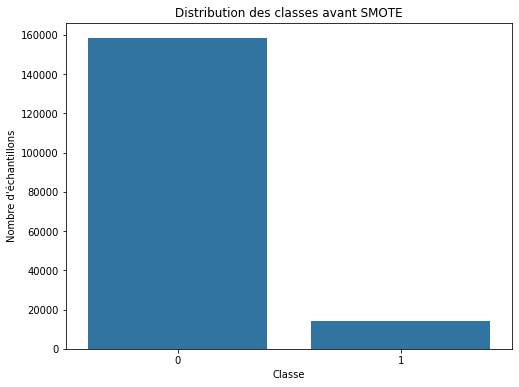

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Dimensions après transformation : (172205, 202)
Distribution des classes après SMOTE:
0    158275
1     63310
Name: TARGET, dtype: int64


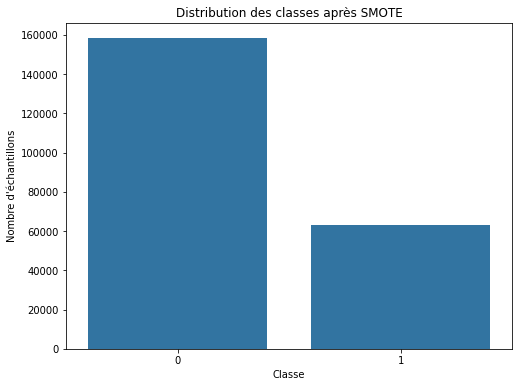

In [118]:
# Vérification des classes de la cible
print("Classes dans y_train_final:", y_train_final.unique())

# 1. Afficher la distribution des classes avant SMOTE
print("Distribution des classes avant SMOTE:")
print(y_train_final.value_counts())

# Affichage sous forme de graphique
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_final)
plt.title('Distribution des classes avant SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()

# 2. Transformation des données d'entrée avec preprocessor
X_train_transformed = preprocessor.fit_transform(X_train_final, y_train_final)


# Vérification après transformation
print("Dimensions après transformation :", X_train_transformed.shape)

# 3. Appliquer SMOTE indépendamment pour visualisation
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train_final)

# 4. Afficher la distribution des classes après SMOTE
print("Distribution des classes après SMOTE:")
print(pd.Series(y_train_res).value_counts())

# Affichage sous forme de graphique
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Distribution des classes après SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()


### Model Xgboost with smote an score metier

In [109]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from imblearn.under_sampling import RandomUnderSampler






# 1. Modèle XGBoost avec une échelle de poids pour les classes déséquilibrées
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=10)

# 2. SMOTE pour l'équilibrage des classes
smote = SMOTE(sampling_strategy=0.4, random_state=42)
# 2. RandomUnderSampler pour équilibrer les classes
#undersampler = RandomUnderSampler(sampling_strategy=0.4, random_state=42)



# 3. Pipeline avec SMOTE et XGBoost
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor), 
    ('smote', smote),  # Appliquer SMOTE pour suréchantillonner les classes minoritaires
    ('model', model_xgb)  # Modèle XGBoost
])

# 4. Fonction de coût métier (10 * FN + FP)
def cost_function(y_true, y_pred_proba, threshold=0.5):
    # Convertir les probabilités en classes binaires en fonction du seuil
    y_pred_bin = (y_pred_proba >= threshold).astype(int)
    
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    # Coût métier : 10 * FN + FP
    return 10 * fn + fp

# 5. Score personnalisé basé sur la fonction de coût métier
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

# 6. Créer un scorer pour la fonction de coût métier
custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'model__n_estimators': [ 220],
    'model__max_depth': [9],
    'model__learning_rate': [0.04],
    'model__colsample_bytree': [1.0],
    'model__gamma': [0.2],
    'model__subsample': [0.8],
    'model__scale_pos_weight': [9],  
    
}
    


# 8. GridSearch pour optimiser les hyperparamètres en fonction du score métier
grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1, verbose=2)




In [61]:

# 9. Entraîner le modèle avec la recherche de grille
grid_search.fit(X_train_final, y_train_final)

#

Fitting 5 folds for each of 1 candidates, totalling 5 fits


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [1.0],
                         'model__gamma': [0.2], 'model__learning_rate': [0.04],
                         'model__max_depth': [9], 'model__n_estimators': [220],
                         'model__scale_pos_weight': [9],
                         'model__subsample': [0.8]},
             scoring=make_scorer(custom_cost_score, greater_is_better=False),
             verbose=2)

In [62]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score

# 7. Résultats de la recherche
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# 8. Prédictions et évaluation
best_model = grid_search.best_estimator_

# Prédire sur les données de test
y_pred_bin = best_model.predict(X_test)  # Classes prédites
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calcul des métriques
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)  # AUC (Area Under the Curve)
accuracy_xgb = accuracy_score(y_test, y_pred_bin)  # Accuracy
f1_xgb = f1_score(y_test, y_pred_bin)  # F1-Score
precision_xgb = precision_score(y_test, y_pred_bin)  # Précision
recall_xgb = recall_score(y_test, y_pred_bin)  # Rappel

# Trouver le seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.05, 0.05)  # Tester des seuils de 0.0 à 1.0 par pas de 0.05
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]  # Calculer le coût pour chaque seuil
best_threshold = thresholds[np.argmin(costs)]  # Trouver le seuil qui minimise le coût

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Precision : {precision_xgb:.4f}')
print(f'Recall : {recall_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarder le modèle final
joblib.dump(best_model, '/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')
joblib.dump(preprocessor, '/home/machou/openclassroom/mlflow_project/models/preprocessor.pkl')

Meilleurs hyperparamètres: {'model__colsample_bytree': 1.0, 'model__gamma': 0.2, 'model__learning_rate': 0.04, 'model__max_depth': 9, 'model__n_estimators': 220, 'model__scale_pos_weight': 9, 'model__subsample': 0.8}
Meilleur score de coût métier: -21746.8
AUC : 0.7625
Accuracy : 0.7992
F1-Score : 0.3039
Precision : 0.2110
Recall : 0.5430
Seuil optimal pour le score métier : 0.4000


['/home/machou/openclassroom/mlflow_project/models/preprocessor.pkl']

/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.4min
[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.5min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.6min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.6min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.7min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
# Récupérer le meilleur modèle de la recherche par grille
best_model = grid_search.best_estimator_

# Accéder au préprocesseur dans le pipeline
preprocessor = best_model.named_steps['preprocessor']

# Accéder à l'encodeur OneHot (en supposant qu'il est dans le second transformateur)
onehot_encoder = preprocessor.transformers_[1][1]  # Accéder au second transformateur

# Vérifier les noms des caractéristiques après l'encodage One-Hot
feature_names_after_encoding = onehot_encoder.get_feature_names_out()

# Afficher les noms des caractéristiques après encodage One-Hot
print("Noms des caractéristiques après encodage One-Hot:", feature_names_after_encoding)


# Exemple de sauvegarde des noms des caractéristiques après encodage
import numpy as np
np.save('/home/machou/openclassroom/mlflow_project/data/feature_names_after_encoding.npy', feature_names_after_encoding)


Noms des caractéristiques après encodage One-Hot: ['low_cardinality__NAME_CONTRACT_TYPE_Cash loans'
 'low_cardinality__NAME_CONTRACT_TYPE_Revolving loans'
 'low_cardinality__CODE_GENDER_F' 'low_cardinality__CODE_GENDER_M'
 'low_cardinality__CODE_GENDER_XNA' 'low_cardinality__FLAG_OWN_CAR_N'
 'low_cardinality__FLAG_OWN_CAR_Y' 'low_cardinality__FLAG_OWN_REALTY_N'
 'low_cardinality__FLAG_OWN_REALTY_Y'
 'low_cardinality__NAME_TYPE_SUITE_Children'
 'low_cardinality__NAME_TYPE_SUITE_Family'
 'low_cardinality__NAME_TYPE_SUITE_Group of people'
 'low_cardinality__NAME_TYPE_SUITE_Other_A'
 'low_cardinality__NAME_TYPE_SUITE_Other_B'
 'low_cardinality__NAME_TYPE_SUITE_Spouse, partner'
 'low_cardinality__NAME_TYPE_SUITE_Unaccompanied'
 'low_cardinality__NAME_INCOME_TYPE_Businessman'
 'low_cardinality__NAME_INCOME_TYPE_Commercial associate'
 'low_cardinality__NAME_INCOME_TYPE_Maternity leave'
 'low_cardinality__NAME_INCOME_TYPE_Pensioner'
 'low_cardinality__NAME_INCOME_TYPE_State servant'
 'low_card

In [35]:
print(best_model.feature_names_in_)  # Liste des colonnes utilisées pour entraîner le modèle


['SK_ID_CURR' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOORSMAX_AVG'

In [63]:

    
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import mlflow
import joblib

# Générer les coordonnées de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score_xgb:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
roc_curve_path = '/home/machou/openclassroom/mlflow_project/models/roc_curve.png'
plt.savefig(roc_curve_path)  # Sauvegarder la courbe ROC comme image
plt.close()

# --- Enregistrement du modèle et des résultats dans MLflow ---
with mlflow.start_run() as run:
    # Log des meilleurs hyperparamètres
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)

    # Log du modèle XGBoost avec SMOTE
    mlflow.sklearn.log_model(best_model, "xgb_model_with_smote_and_cost")

    # Log des métriques d'évaluation
    mlflow.log_metric("auc", auc_score_xgb)
    mlflow.log_metric("accuracy", accuracy_xgb)
    mlflow.log_metric("f1_score", f1_xgb)
    mlflow.log_metric("precision", precision_xgb)
    mlflow.log_metric("recall", recall_xgb)
    mlflow.log_metric("best_threshold", best_threshold)

    # Log du meilleur score de coût métier
    mlflow.log_metric("best_cost_score", -grid_search.best_score_)

    # Log de la courbe ROC comme artefact
    mlflow.log_artifact(roc_curve_path, artifact_path="plots")
    

2024/12/04 10:40:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/04 10:40:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-grub-856 at: http://localhost:5000/#/experiments/0/runs/c767a154d6174462a185f363eba2209b.
2024/12/04 10:40:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


In [ ]:
### Matrice de Confusion

Vrais Positifs (TP) : 3348 : Cas où le modèle a correctement prédit la classe positive.
Faux Positifs (FP) : 15773 : Cas où le modèle a prédit à tort la classe positive.
Faux Négatifs (FN) : 1617 : Cas où le modèle a prédit à tort la classe négative.
Vrais Négatifs (TN) : 40765 : Cas où le modèle a correctement prédit la classe négative.


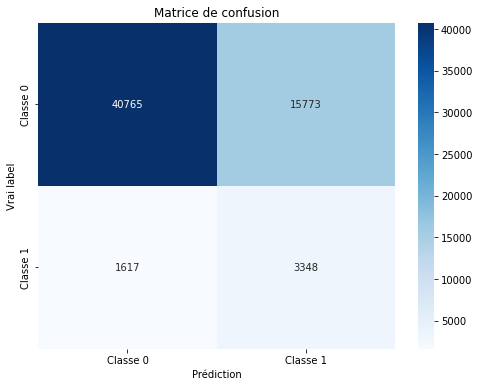

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")

# 4. Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion')
plt.show()


In [ ]:
### model mieux optimisé

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib



# Gestion des classes déséquilibrées avec SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Initialisation du modèle XGBoost avec pondération des classes
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=12)

# Pipeline complet : Prétraitement -> SMOTE -> Modèle
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', model_xgb)
])

# Définition de la fonction de coût métier : 10 * FN + FP
def cost_function(y_true, y_pred_proba, threshold=0.5):
    y_pred_bin = (y_pred_proba >= threshold).astype(int)  # Conversion des probabilités en classes
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()  # Matrice de confusion
    return 10 * fn + fp  # Coût métier

# Création d'un scorer basé sur la fonction de coût
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'model__n_estimators': [ 220],
    'model__max_depth': [10],
    'model__learning_rate': [0.04],
    'model__colsample_bytree': [1.0],
    'model__gamma': [0.2],
    'model__subsample': [0.8],
    'model__scale_pos_weight': [11],  
    
}


# Grille d'hyperparamètres pour GridSearchCV
#param_grid = {
  # 'model__n_estimators': [160],
 #   'model__max_depth': [8],
 #   'model__learning_rate': [0.04],
    #'model__subsample': [1.0],
  #  'model__colsample_bytree': [1.0],
  #  'model__gamma': [0.2],
   # 'model__min_child_weight': [5],
   # 'model__reg_alpha': [0.01],  # L1 Regularization
   # 'model__reg_lambda': [1.0],
#}


# Recherche d'hyperparamètres avec validation croisée stratifiée
grid_search = GridSearchCV(
    pipeline_xgb,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring=custom_scorer,
    n_jobs=-1
)


In [17]:

# Entraînement du modèle
grid_search.fit(X_train_final, y_train_final)



/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_R...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [1.0],
                         'model__gamma': [0.2], 'model__learning_rate': [0.04],
                         'model__max_depth': [10], 'model__n_estimators': [220],
                         'model__scale_pos_weight': [11],
                         'model__subsample': [0.8]},
             scoring=make_scorer(custom_cost_score, greater_is_better=False))

In [18]:
# Meilleurs hyperparamètres et score associé
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# Prédictions sur les données de test
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des performances
y_pred_bin = (y_pred_proba >= 0.5).astype(int)  # Classes prédictes avec seuil de 0.5
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)  # AUC
accuracy_xgb = accuracy_score(y_test, y_pred_bin)  # Accuracy
f1_xgb = f1_score(y_test, y_pred_bin)  # F1-score

# Recherche du seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.0, 0.01)#thresholds = np.arange(0.0, 1.05, 0.05)
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarde du meilleur modèle
#joblib.dump(best_model, '/path/to/model_xgb_with_smote.pkl')


Meilleurs hyperparamètres: {'model__colsample_bytree': 1.0, 'model__gamma': 0.2, 'model__learning_rate': 0.04, 'model__max_depth': 10, 'model__n_estimators': 220, 'model__scale_pos_weight': 11, 'model__subsample': 0.8}
Meilleur score de coût métier: -22064.2
AUC : 0.7565
Accuracy : 0.7914
F1-Score : 0.2915
Seuil optimal pour le score métier : 0.3700


In [38]:
# Séparation des données d'origine en train et test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Prétraitement et transformation sur l'ensemble de test
X_test_transformed = preprocessor.transform(X_test)

# Initialisation de l'explainer SHAP avec votre modèle
explainer = shap.Explainer(best_model.named_steps['model'])

# Calcul des valeurs SHAP pour les données transformées de test
shap_values = explainer(X_test_transformed)




NameError: name 'shap' is not defined

In [ ]:
# Visualisation de l'importance globale des caractéristiques
shap.summary_plot(shap_values, X_test_transformed)

In [ ]:
# Si X_test est un DataFrame pandas
print("Noms des colonnes dans X_test:")
print(X_test.columns)

# Après transformation, X_test_transformed peut être un tableau NumPy, donc utilisez all_feature_names
print("\nNoms des colonnes après transformation:")
print(all_feature_names)


In [ ]:
# Affichage de l'importance globale des caractéristiques sous forme de graphique à barres
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")


In [ ]:
# Appliquer la transformation sur X_test pour voir le résultat
X_test_transformed = preprocessor.transform(X_test)

# Affichez les dimensions de X_test_transformed
print("Dimensions de X_test_transformed:", X_test_transformed.shape)


In [ ]:
# utlisation de RandomunderSampler a la place de smote pour comparer les resultat :

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler  # Pour l'undersampling
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# Exemple de données (remplacez par vos données)
# X_train = train_data.drop(columns=['TARGET'])
# y_train = train_data['TARGET']

# Vérification des données cibles
print("Aperçu des données cibles avant transformation :")
print(y_train.head())
print("Valeurs uniques des cibles :")
print(y_train.unique())



# Gestion des classes déséquilibrées avec RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersampling

# Initialisation du modèle XGBoost avec pondération des classes
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=10)

# Pipeline complet : Prétraitement -> RandomUnderSampler -> Modèle
pipeline_xgb_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('rus', rus),  # Application de l'undersampling
    ('model', model_xgb)
])

# Affichage de la taille des données après l'undersampling, avant l'entraînement
# Appliquer RandomUnderSampler pour voir les effets sur la taille des données
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
#print(f"Taille des données après l'undersampling - X_train : {X_train_resampled.shape}, y_train : {y_train_resampled.shape}")

# Définition de la fonction de coût métier : 10 * FN + FP
def cost_function(y_true, y_pred_proba, threshold=0.5):
    y_pred_bin = (y_pred_proba >= threshold).astype(int)  # Conversion des probabilités en classes
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()  # Matrice de confusion
    return 10 * fn + fp  # Coût métier

# Création d'un scorer basé sur la fonction de coût
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'model__n_estimators': [150],
    'model__max_depth': [9],
    'model__learning_rate': [0.1],
    'model__colsample_bytree': [0.8],
    'model__gamma': [0.1],
    'model__subsample': [0.8],
    'model__scale_pos_weight': [8],  
}

# Recherche d'hyperparamètres avec validation croisée stratifiée
grid_search = GridSearchCV(
    pipeline_xgb_rus,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring=custom_scorer,
    n_jobs=-1
)

# Entraînement du modèle
grid_search.fit(X_train_final, y_train_final)

# Meilleurs hyperparamètres et score associé
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# Prédictions sur les données de test
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des performances
y_pred_bin = (y_pred_proba >= 0.5).astype(int)  # Classes prédictes avec seuil de 0.5
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)  # AUC
accuracy_xgb = accuracy_score(y_test, y_pred_bin)  # Accuracy
f1_xgb = f1_score(y_test, y_pred_bin)  # F1-score

# Recherche du seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.0, 0.01)
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarde du meilleur modèle
#joblib.dump(best_model, '/path/to/model_xgb_with_random_under_sampler.pkl')

# Afficher la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")


Aperçu des données cibles avant transformation :
181648    0
229245    0
122525    1
306311    1
300658    0
Name: TARGET, dtype: int64
Valeurs uniques des cibles :
[0 1]


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Meilleurs hyperparamètres: {'model__colsample_bytree': 0.8, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 150, 'model__scale_pos_weight': 8, 'model__subsample': 0.8}
Meilleur score de coût métier: -23035.6
AUC : 0.7490
Accuracy : 0.5376
F1-Score : 0.2225
Seuil optimal pour le score métier : 0.6700
Vrais Positifs (TP) : 3384 : Cas où le modèle a correctement prédit la classe positive.
Faux Positifs (FP) : 17222 : Cas où le modèle a prédit à tort la classe positive.
Faux Négatifs (FN) : 1581 : Cas où le modèle a prédit à tort la classe négative.
Vrais Négatifs (TN) : 39316 : Cas où le modèle a correctement prédit la classe négative.


### Model light lgbm with smote and score metier

In [68]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb  # Importer LightGBM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
import joblib
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score


# 3. SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy=0.4, random_state=42)

# 4. Modèle LightGBM
model_lgb = lgb.LGBMClassifier(random_state=42, scale_pos_weight=10)

# 5. Créer un pipeline avec SMOTE dans un pipeline ImbPipeline
pipeline_lgb = ImbPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('smote', smote),  # SMOTE pour suréchantillonner les classes minoritaires
    ('model', model_lgb)  # LightGBM
])

# Fonction de coût métier (10 * FN + FP)
def cost_function(y_true, y_pred_proba, threshold=0.5):
    # Convertir les probabilités en classes binaires en fonction du seuil
    y_pred_bin = (y_pred_proba >= threshold).astype(int)

    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    # Coût métier : 10 * FN + FP
    return 10 * fn + fp

# Score personnalisé basé sur la fonction de coût métier
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

# Créer un scorer pour la fonction de coût métier
custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Score pour l'AUC (à ajouter pour contrôle)
def auc_score(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba)

# Créer un scorer pour l'AUC
auc_scorer = make_scorer(auc_score, greater_is_better=True)

# Score pour l'accuracy (à ajouter pour contrôle)
def accuracy_score_custom(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Créer un scorer pour l'accuracy
accuracy_scorer = make_scorer(accuracy_score_custom, greater_is_better=True)

# 6. Recherche d'hyperparamètres avec GridSearchCV (optionnel)
param_grid = {
   'model__n_estimators': [150],
    'model__max_depth': [8],
    'model__learning_rate': [0.08],
    'model__colsample_bytree': [1.0],
}

grid_search = GridSearchCV(pipeline_lgb, param_grid, cv=StratifiedKFold(n_splits=5), 
                           scoring=custom_scorer, n_jobs=-1)

# Entraîner le modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(X_train_final, y_train_final)

# 7. Résultats de la recherche
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# 8. Prédictions et évaluation
best_model_lgb = grid_search.best_estimator_

# Prédire sur les données de test
y_pred_proba = best_model_lgb.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

from sklearn.metrics import f1_score

# Calcul des prédictions sur X_test
y_pred_bin = best_model_lgb.predict(X_test)  # Classes prédites pour la précision et le F1-score
y_pred_proba = best_model_lgb.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calcul de l'AUC (Area Under the Curve)
auc_score_lgb = roc_auc_score(y_test, y_pred_proba)

# Calcul de l'Accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_bin)

# Calcul du F1-Score
f1_lgb = f1_score(y_test, y_pred_bin)


precision_lgb = precision_score(y_test, y_pred_bin)  # Précision
recall_lgb = recall_score(y_test, y_pred_bin)  # Rappel

# Trouver le seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.05, 0.05)  # Tester des seuils de 0.0 à 1.0 par pas de 0.05
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]  # Calculer le coût pour chaque seuil
best_threshold = thresholds[np.argmin(costs)]  # Trouver le seuil qui minimise le coût

# Affichage des résultats
print(f'AUC_lgb : {auc_score_lgb:.4f}')
print(f'Accuracy_lgb : {accuracy_lgb:.4f}')
print(f'F1-Score_lgb : {f1_lgb:.4f}')
print(f'precision_lgb : {precision_lgb:.4f}')
print(f'recall_lgb: {recall_lgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarder le modèle final
joblib.dump(best_model_lgb, '/home/machou/openclassroom/mlflow_project/models/lgb_model_with_smote_and_score_metier_etape_par_etape.pkl')


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 72367, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43450
[LightGBM] [Info] Number of data points in the train set: 253285, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916293
[LightGBM] [Info] Start training from score -0.916293
Meilleurs hyperparamètres: {'model__colsample_bytree': 1.0, 'model__gamma': 0.2, 'model__learning_rate': 0.08, 'model__max_depth': 8, 'model__n_estimators': 150}
Meilleur score de coût métier: -20539.6
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
AUC_lgb : 0.7694
Accuracy_lgb : 0.7245
F1-Score_lgb : 0.2851
precision

['/home/machou/openclassroom/mlflow_project/models/lgb_model_with_smote_and_score_metier_etape_par_etape.pkl']

In [69]:
# --- Enregistrement du modèle dans MLflow ---
with mlflow.start_run() as run:
    # Log des meilleurs hyperparamètres
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)

    # Log du modèle LightGBM avec SMOTE
    mlflow.sklearn.log_model(best_model_lgb, "lgb_model_with_smote_and_cost")

    # Log des métriques d'évaluation
    mlflow.log_metric("auc", auc_score_lgb)
    mlflow.log_metric("accuracy", accuracy_lgb)
    mlflow.log_metric("f1_score", f1_lgb)
    mlflow.log_metric("precision", precision_lgb)
    mlflow.log_metric("recall", recall_lgb)
    mlflow.log_metric("best_threshold", best_threshold)

    # Log du meilleur score de coût métier
    mlflow.log_metric("best_cost_score", -grid_search.best_score_)

2024/11/26 19:19:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/26 19:19:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-donkey-680 at: http://localhost:5000/#/experiments/0/runs/a57239bd297e4e37ab79f745b76362d8.
2024/11/26 19:19:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 57894, number of negative: 144735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.513449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43444
[LightGBM] [Info] Number of data points in the train set: 202629, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Warning] Unknown parameter: gamma


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 57893, number of negative: 144734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.427890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43374
[LightGBM] [Info] Number of data points in the train set: 202627, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916301
[LightGBM] [Info] Start training from score -0.916301
[LightGBM] [Warning] Unknown parameter: gamma


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 57893, number of negative: 144734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.438394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43377
[LightGBM] [Info] Number of data points in the train set: 202627, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916301
[LightGBM] [Info] Start training from score -0.916301
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 57893, number of negative: 144734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.624270 seconds.
You can set `force_col_wise=true

/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 57894, number of negative: 144735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42896
[LightGBM] [Info] Number of data points in the train set: 202629, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Warning] Unknown parameter: gamma


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Vrais Positifs (TP) : 3379 : Cas où le modèle a correctement prédit la classe positive.
Faux Positifs (FP) : 15356 : Cas où le modèle a prédit à tort la classe positive.
Faux Négatifs (FN) : 1586 : Cas où le modèle a prédit à tort la classe négative.
Vrais Négatifs (TN) : 41182 : Cas où le modèle a correctement prédit la classe négative.


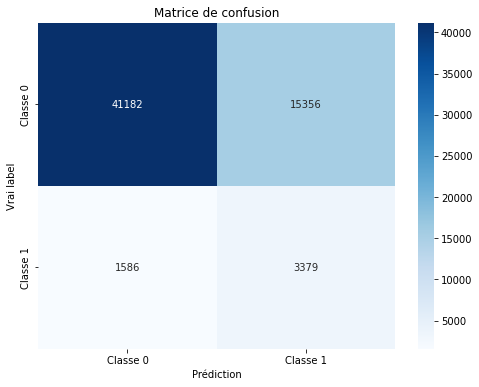

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")

# 4. Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion')
plt.show()


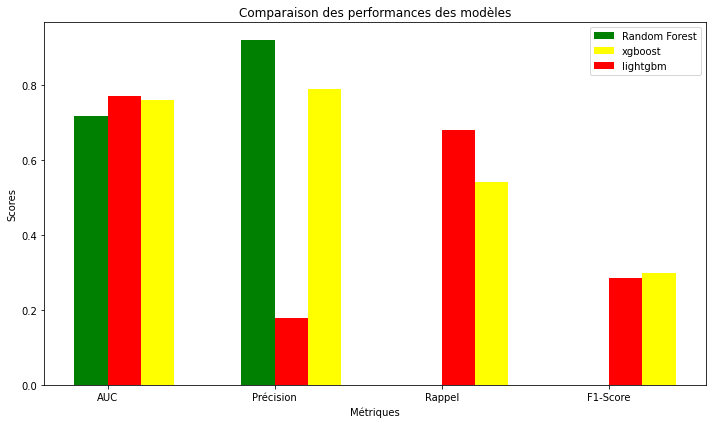

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Données de performance
metrics = ['AUC', 'Précision', 'Rappel', 'F1-Score']

random_forest_scores = [0.7177, 0.92, 0.00, 0.00]  # Exemple de données pour Random Forest
xgboost_score = [0.76, 0.79, 0.54, 0.30]  # Exemple de données pour xgboost
lightgbm_scores = [0.7694, 0.1804, 0.6806,  0.2851]  # Exemple de données pourlightgbm

# Configuration du graphique
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Déplacement des barres sur l'axe des x pour éviter les chevauchements
ax.bar(x - width/2, random_forest_scores, width, label='Random Forest', color='green')

ax.bar(x + width*1.5, xgboost_score, width, label='xgboost', color='yellow')
ax.bar(x + width/2, lightgbm_scores, width, label='lightgbm', color='red')
# Labels et légende
ax.set_xlabel('Métriques')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des performances des modèles')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.0min
[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.1min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.1min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.5min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END model__colsample_bytree=1.0, model__gamma=0.2, model__learning_rate=0.04, model__max_depth=9, model__n_estimators=220, model__scale_pos_weight=9, model__subsample=0.8; total time= 2.5min


/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


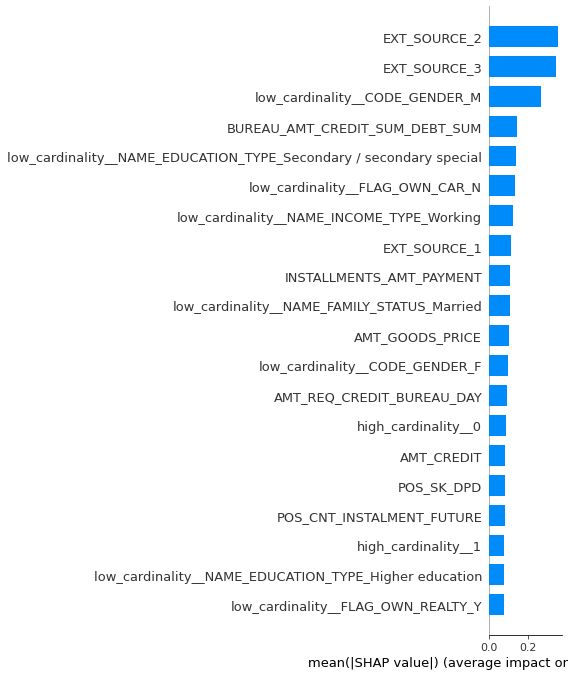

In [39]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger le modèle XGBoost
model = joblib.load('/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')

# Appliquer d'abord le préprocesseur pour transformer les données de test
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Récupérer les noms de caractéristiques après transformation
# Accéder aux transformateurs dans le ColumnTransformer
column_transformer = model.named_steps['preprocessor']

# 1. Identifier l'étape OneHotEncoder dans le ColumnTransformer (index 1, première transformation catégorielle)
onehot_transformer = column_transformer.transformers_[1][1]  # 'transformers_' est une liste avec les transformations

# 2. Extraire les noms des colonnes après OneHotEncoder
onehot_columns = onehot_transformer.get_feature_names_out(input_features=column_transformer.transformers_[1][2])

# 3. Extraire les noms des colonnes numériques
numerical_columns = column_transformer.transformers_[0][2]  # Colonnes numériques d'origine

# 4. Combiner les colonnes numériques et OneHot pour obtenir tous les noms des caractéristiques
all_feature_names = np.concatenate([numerical_columns, onehot_columns])

# Créer un explainer SHAP en fonction du modèle XGBoost
explainer = shap.TreeExplainer(model.named_steps['model'])  # Remplacer 'model' par le nom exact du modèle dans votre pipeline

# Calcul des valeurs SHAP pour X_test
shap_values = explainer.shap_values(X_test_transformed)

# Visualisation des résultats sous forme de bar plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names, plot_type="bar")

# Sauvegarder le graphique si nécessaire :
# plt.savefig('shap_feature_importance_bar_plot.png')


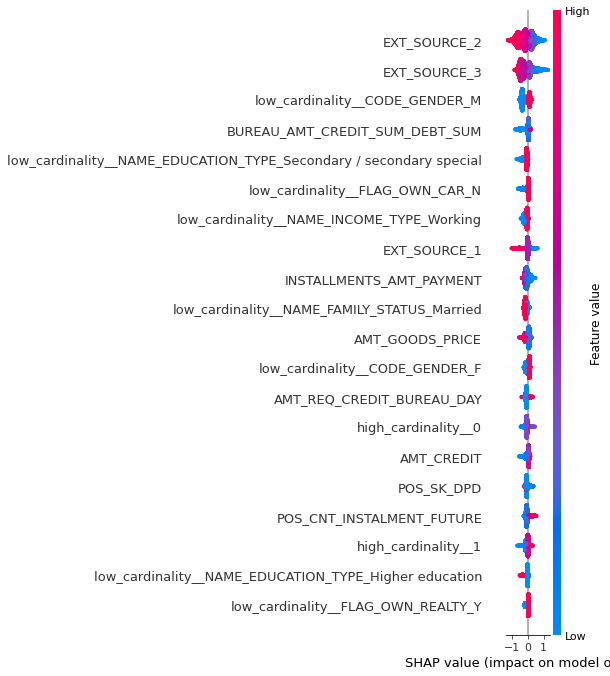

In [40]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger le modèle XGBoost
model = joblib.load('/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')

# Appliquer d'abord le préprocesseur pour transformer les données de test
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Récupérer les noms de caractéristiques après transformation
# Accéder aux transformateurs dans le ColumnTransformer
column_transformer = model.named_steps['preprocessor']

# 1. Identifier l'étape OneHotEncoder dans le ColumnTransformer (index 1, première transformation catégorielle)
onehot_transformer = column_transformer.transformers_[1][1]  # 'transformers_' est une liste avec les transformations

# 2. Extraire les noms des colonnes après OneHotEncoder
onehot_columns = onehot_transformer.get_feature_names_out(input_features=column_transformer.transformers_[1][2])

# 3. Extraire les noms des colonnes numériques
numerical_columns = column_transformer.transformers_[0][2]  # Colonnes numériques d'origine

# 4. Combiner les colonnes numériques et OneHot pour obtenir tous les noms des caractéristiques
all_feature_names = np.concatenate([numerical_columns, onehot_columns])

# Créer un explainer SHAP en fonction du modèle XGBoost
explainer = shap.TreeExplainer(model.named_steps['model'])  # Remplacer 'model' par le nom exact du modèle dans votre pipeline

# Calcul des valeurs SHAP pour X_test
shap_values = explainer.shap_values(X_test_transformed)

# Visualisation des résultats sous forme de summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)

# Sauvegarder le graphique si nécessaire :
# plt.savefig('shap_feature_importance_summary_plot.png')


In [ ]:
### importante feature

In [42]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger le modèle XGBoost
model = joblib.load('/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')

# Appliquer d'abord le préprocesseur pour transformer les données de test
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Récupérer les noms de caractéristiques après transformation
# Accéder aux transformateurs dans le ColumnTransformer
column_transformer = model.named_steps['preprocessor']

# Identifier l'étape OneHotEncoder dans le ColumnTransformer (index 1)
onehot_transformer = column_transformer.transformers_[1][1]  # 'transformers_' est une liste avec les transformations

# Extraire les noms des colonnes après OneHotEncoder
onehot_columns = onehot_transformer.get_feature_names_out(input_features=column_transformer.transformers_[1][2])

# Extraire les noms des colonnes numériques
numerical_columns = column_transformer.transformers_[0][2]  # Colonnes numériques d'origine

# Combiner les colonnes numériques et OneHot pour obtenir tous les noms des caractéristiques
all_feature_names = np.concatenate([numerical_columns, onehot_columns])

# Créer un explainer SHAP en fonction du modèle XGBoost
explainer = shap.TreeExplainer(model.named_steps['model'])  # Remplacer 'model' par le nom exact du modèle dans votre pipeline

# Calcul des valeurs SHAP pour X_test
shap_values = explainer.shap_values(X_test_transformed)

# Extraire l'importance des caractéristiques (moyenne des valeurs absolues SHAP sur toutes les observations)
shap_importance = np.abs(shap_values).mean(axis=0)

# Créer un DataFrame pour lier les importances aux noms des caractéristiques
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': shap_importance
})

# Trier les caractéristiques par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)



                                               Feature  Importance
29                                        EXT_SOURCE_2    0.354728
30                                        EXT_SOURCE_3    0.344631
139                     low_cardinality__CODE_GENDER_M    0.267618
108                     BUREAU_AMT_CREDIT_SUM_DEBT_SUM    0.140703
164  low_cardinality__NAME_EDUCATION_TYPE_Secondary...    0.138415
141                    low_cardinality__FLAG_OWN_CAR_N    0.130409
159          low_cardinality__NAME_INCOME_TYPE_Working    0.122481
28                                        EXT_SOURCE_1    0.114252
125                           INSTALLMENTS_AMT_PAYMENT    0.109518
166        low_cardinality__NAME_FAMILY_STATUS_Married    0.106875


NameError: name 'importance_df' is not defined

In [44]:

# Sauvegarder l'importances des caractéristiques dans un fichier CSV
feature_importance_df.to_csv('/home/machou/openclassroom/projet/api/data/shap_feature_importance.csv', index=False)

# Affichage des 10 caractéristiques les plus importantes
print(feature_importance_df.head(10))


                                               Feature  Importance
29                                        EXT_SOURCE_2    0.354728
30                                        EXT_SOURCE_3    0.344631
139                     low_cardinality__CODE_GENDER_M    0.267618
108                     BUREAU_AMT_CREDIT_SUM_DEBT_SUM    0.140703
164  low_cardinality__NAME_EDUCATION_TYPE_Secondary...    0.138415
141                    low_cardinality__FLAG_OWN_CAR_N    0.130409
159          low_cardinality__NAME_INCOME_TYPE_Working    0.122481
28                                        EXT_SOURCE_1    0.114252
125                           INSTALLMENTS_AMT_PAYMENT    0.109518
166        low_cardinality__NAME_FAMILY_STATUS_Married    0.106875


In [45]:
# Sauvegarder l'importances des caractéristiques sous le format .npy
np.save('/home/machou/openclassroom/projet/api/data/shap_feature_importance.npy', shap_importance)

# Sauvegarder les noms des caractéristiques associées
np.save('/home/machou/openclassroom/projet/api/data/shap_feature_names.npy', all_feature_names)


### courbe ROC 

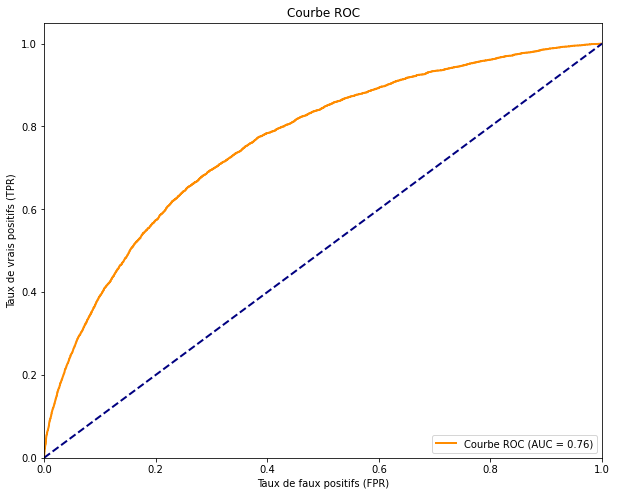

AUC (Area Under the Curve): 0.7625


In [41]:
import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Charger le modèle XGBoost
model = joblib.load('/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')

# Supposons que vous avez des données d'entrée X_test (transformées si nécessaire)
# Appliquez d'abord le préprocesseur pour transformer les données de test
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Prédictions probabilistes pour X_test
y_pred_proba = model.named_steps['model'].predict_proba(X_test_transformed)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Affichage de l'AUC
print(f"AUC (Area Under the Curve): {roc_auc:.4f}")


Une droite plate indique peu de lien entre le montant du crédit et le défaut.

In [ ]:
### enregistrer le model dans mlflow

In [ ]:

# Lancer un run MLflow
with mlflow.start_run(run_name="XGBoost_with_SMOTE_and_Cost_Score") as run:
    
    # Enregistrer les paramètres (hyperparamètres du modèle)
    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("max_depth", 8)
    mlflow.log_param("learning_rate", 0.06)
    mlflow.log_param("subsample", 1.0)
    mlflow.log_param("colsample_bytree", 1.0)
    mlflow.log_param("gamma", 1)
    mlflow.log_param("min_child_weight", 5)
    mlflow.log_param("scale_pos_weight", 10)
    mlflow.log_param("reg_alpha", 0.01)
    mlflow.log_param("reg_lambda", 1.0)
    
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc_score)
    mlflow.log_metric("cost_metric", min_cost)
    mlflow.log_metric("optimal_threshold", best_threshold)

    # Tracer et enregistrer des graphiques
    plt.figure()
    RocCurveDisplay.from_predictions(y_test, y_pred_proba_xgb, name=f"ROC curve (AUC = {auc_score:.2f})")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")  # Enregistrer le graphique ROC dans MLflow

    # Enregistrer le modèle XGBoost dans MLflow avec signature et exemple d'entrée
    mlflow.xgboost.log_model(
        best_model.named_steps['model'],  # Enregistrez le modèle (assurez-vous que votre modèle est le bon dans le pipeline)
        "xgboost_model",
        signature=signature,
        input_example=input_example
    )

    # Ajouter une note au run pour documenter le seuil métier
    mlflow.set_tag("business_optimal_threshold", f"{best_threshold:.4f}")

print("Modèle et métriques enregistrés dans MLflow avec signature et exemple d'entrée.")

